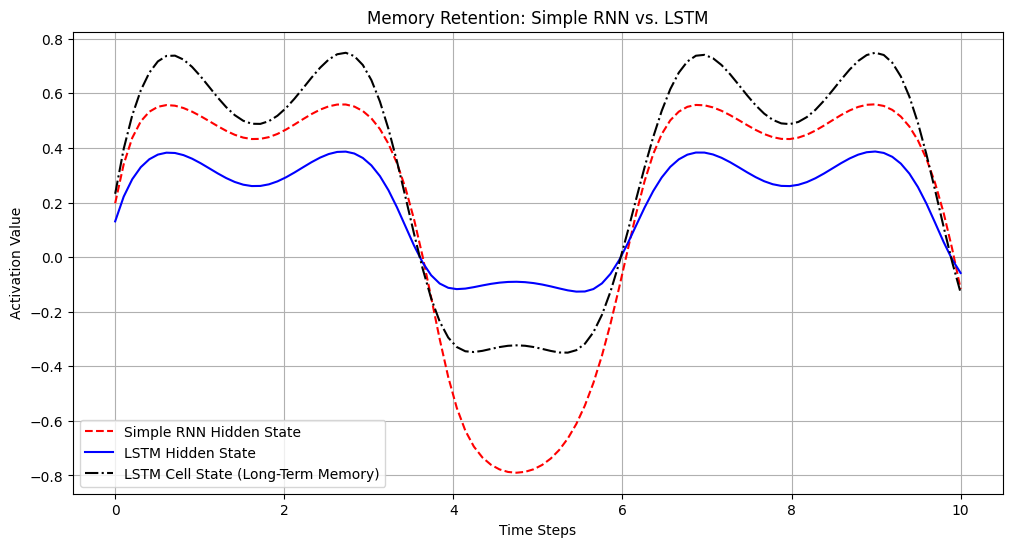

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define sigmoid function (used for LSTM gates)
def sigmoid(x):
    return 1 / (1 + ops.exp(-x))

# Define a basic RNN update rule (no memory gating)
def simple_rnn_update(prev_hidden, input_val, w_h=0.6, w_x=0.4):
    return nn.modules.activations.tanh(w_h * prev_hidden + w_x * input_val)

# Generate a time-varying input signal (oscillatory function)
time_steps = tensor.linspace(0, 10, 100)
input_signal = ops.sin(time_steps) + 0.5 * ops.cos(2 * time_steps)  # Example input sequence

# Simulate LSTM gate activations
forget_gate_values = sigmoid(0.5 * input_signal - 0.2)  # Example weighting for forget gate
input_gate_values = sigmoid(0.7 * input_signal + 0.1)  # Example weighting for input gate
output_gate_values = sigmoid(0.6 * input_signal)  # Example weighting for output gate

# Simulate LSTM cell memory evolution
candidate_memory_values = nn.modules.activations.tanh(0.8 * input_signal)  # Candidate memory update
from ember_ml import ops
from ember_ml.nn import tensor
# Initialize variables for Simple RNN and LSTM
rnn_hidden_state = tensor.zeros_like(time_steps)
lstm_hidden_state = tensor.zeros_like(time_steps)
lstm_cell_state = tensor.zeros_like(time_steps)

# Initial states
rnn_hidden = 0
lstm_hidden = 0
lstm_cell = 0

# Simulate both Simple RNN and LSTM
for t in range(len(time_steps)):
    # Simple RNN updates
    rnn_hidden = simple_rnn_update(rnn_hidden, input_signal[t])
    rnn_hidden_state[t] = rnn_hidden

    # LSTM updates (using the same gate mechanisms)
    forget = forget_gate_values[t]
    input_g = input_gate_values[t]
    output_g = output_gate_values[t]
    candidate_memory = candidate_memory_values[t]

    lstm_cell = forget * lstm_cell + input_g * candidate_memory  # Cell state update
    lstm_hidden = output_g * nn.modules.activations.tanh(lstm_cell)  # Hidden state update

    lstm_hidden_state[t] = lstm_hidden
    lstm_cell_state[t] = lstm_cell

# Plot Simple RNN vs. LSTM hidden states over time
plt.figure(figsize=(12, 6))
plt.plot(time_steps, rnn_hidden_state, label="Simple RNN Hidden State", linestyle="dashed", color="red")
plt.plot(time_steps, lstm_hidden_state, label="LSTM Hidden State", linestyle="solid", color="blue")
plt.plot(time_steps, lstm_cell_state, label="LSTM Cell State (Long-Term Memory)", linestyle="dashdot", color="black")

# Formatting
plt.xlabel("Time Steps")
plt.ylabel("Activation Value")
plt.title("Memory Retention: Simple RNN vs. LSTM")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [2]:
import torch
import torch.nn as nn

class xLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(xLSTMCell, self).__init__()
        self.hidden_size = hidden_size

        # Weight matrices for gates
        self.W_f = nn.Linear(input_size + hidden_size + hidden_size, hidden_size)  # Forget Gate (incorporates past memory)
        self.W_i = nn.Linear(input_size + hidden_size + hidden_size, hidden_size)  # Input Gate
        self.W_c = nn.Linear(input_size + hidden_size, hidden_size)  # Candidate Memory Update
        self.W_o = nn.Linear(input_size + hidden_size + hidden_size, hidden_size)  # Output Gate

        # LeCun Tanh activation
        self.lecun_tanh = lambda x: 1.7159 * torch.tanh(2/3 * x)

    def forward(self, x, hidden):
        h_prev, c_prev = hidden

        # Compute Forget Gate (with adaptive decay)
        f_t = torch.sigmoid(self.W_f(torch.cat([x, h_prev, c_prev], dim=1)))
        decay = torch.exp(-0.1 * torch.abs(c_prev))
        f_t = f_t * decay  # Adaptive decay

        # Compute Input Gate (cross-gated)
        i_t = torch.sigmoid(self.W_i(torch.cat([x, h_prev, f_t], dim=1)))

        # Candidate memory update (LeCun Tanh)
        c_hat = self.lecun_tanh(self.W_c(torch.cat([x, h_prev], dim=1)))

        # Compute new cell state
        c_t = f_t * c_prev + i_t * c_hat

        # Compute Output Gate (context-aware)
        o_t = torch.sigmoid(self.W_o(torch.cat([x, h_prev, c_t], dim=1)))

        # Final hidden state update
        h_t = o_t * torch.tanh(c_t)

        return h_t, c_t

class xLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(xLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.cells = nn.ModuleList([xLSTMCell(input_size if i == 0 else hidden_size, hidden_size) for i in range(num_layers)])

    def forward(self, x, hidden):
        h, c = hidden
        for i, cell in enumerate(self.cells):
            h[i], c[i] = cell(x, (h[i], c[i]))
        return h, c

    def init_hidden(self, batch_size):
        h = [torch.zeros(batch_size, self.hidden_size) for _ in range(self.num_layers)]
        c = [torch.zeros(batch_size, self.hidden_size) for _ in range(self.num_layers)]
        return torch.stack(h), torch.stack(c)

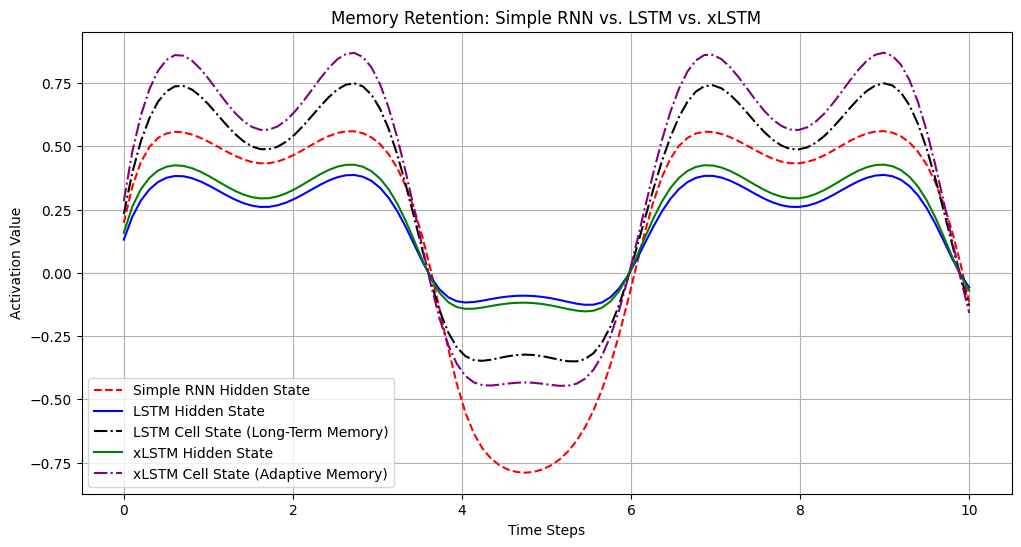

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_xLSTM_vs_LSTM_vs_RNN():
    # Generate a time-varying input signal (oscillatory function)
    time_steps = tensor.linspace(0, 10, 100)
    input_signal = ops.sin(time_steps) + 0.5 * ops.cos(2 * time_steps)  # Example input sequence

    # Define sigmoid function (used for LSTM gates)
    def sigmoid(x):
        return 1 / (1 + ops.exp(-x))

    # Define a basic RNN update rule (no memory gating)
    def simple_rnn_update(prev_hidden, input_val, w_h=0.6, w_x=0.4):
        return nn.modules.activations.tanh(w_h * prev_hidden + w_x * input_val)

    # Define LeCun Tanh function for xLSTM
    def lecun_tanh(x):
        return 1.7159 * nn.modules.activations.tanh(2/3 * x)

    # Simulate LSTM gate activations
    forget_gate_values = sigmoid(0.5 * input_signal - 0.2)  # Example weighting for forget gate
    input_gate_values = sigmoid(0.7 * input_signal + 0.1)  # Example weighting for input gate
    output_gate_values = sigmoid(0.6 * input_signal)  # Example weighting for output gate

    # Simulate xLSTM gate activations (adaptive decay on forget gate)
    adaptive_decay = ops.exp(-0.1 * ops.abs(input_signal))
    x_forget_gate_values = forget_gate_values * adaptive_decay  # Decay-adjusted forget gate
    x_input_gate_values = sigmoid(0.7 * input_signal + 0.1 + 0.2 * x_forget_gate_values)  # Cross-gated input gate

    # Simulate cell memory evolution
    candidate_memory_values = nn.modules.activations.tanh(0.8 * input_signal)  # Standard LSTM candidate memory
    x_candidate_memory_values = lecun_tanh(0.8 * input_signal)  # xLSTM candidate memory with LeCun Tanh

    # Initialize variables for Simple RNN, LSTM, and xLSTM
    rnn_hidden_state = tensor.zeros_like(time_steps)
    lstm_hidden_state = tensor.zeros_like(time_steps)
    lstm_cell_state = tensor.zeros_like(time_steps)
    xlstm_hidden_state = tensor.zeros_like(time_steps)
    xlstm_cell_state = tensor.zeros_like(time_steps)

    # Initial states
    rnn_hidden = 0
    lstm_hidden = 0
    lstm_cell = 0
    xlstm_hidden = 0
    xlstm_cell = 0

    # Simulate Simple RNN, LSTM, and xLSTM
    for t in range(len(time_steps)):
        # Simple RNN updates
        rnn_hidden = simple_rnn_update(rnn_hidden, input_signal[t])
        rnn_hidden_state[t] = rnn_hidden

        # LSTM updates
        forget = forget_gate_values[t]
        input_g = input_gate_values[t]
        output_g = output_gate_values[t]
        candidate_memory = candidate_memory_values[t]

        lstm_cell = forget * lstm_cell + input_g * candidate_memory  # Cell state update
        lstm_hidden = output_g * nn.modules.activations.tanh(lstm_cell)  # Hidden state update

        lstm_hidden_state[t] = lstm_hidden
        lstm_cell_state[t] = lstm_cell

        # xLSTM updates (adaptive memory decay and LeCun Tanh)
        x_forget = x_forget_gate_values[t]
        x_input_g = x_input_gate_values[t]
        x_output_g = output_gate_values[t]
        x_candidate_memory = x_candidate_memory_values[t]

        xlstm_cell = x_forget * xlstm_cell + x_input_g * x_candidate_memory  # Cell state update
        xlstm_hidden = x_output_g * nn.modules.activations.tanh(xlstm_cell)  # Hidden state update

        xlstm_hidden_state[t] = xlstm_hidden
        xlstm_cell_state[t] = xlstm_cell

    # Plot Simple RNN vs. LSTM vs. xLSTM hidden states over time
    plt.figure(figsize=(12, 6))
    plt.plot(time_steps, rnn_hidden_state, label="Simple RNN Hidden State", linestyle="dashed", color="red")
    plt.plot(time_steps, lstm_hidden_state, label="LSTM Hidden State", linestyle="solid", color="blue")
    plt.plot(time_steps, lstm_cell_state, label="LSTM Cell State (Long-Term Memory)", linestyle="dashdot", color="black")
    plt.plot(time_steps, xlstm_hidden_state, label="xLSTM Hidden State", linestyle="solid", color="green")
    plt.plot(time_steps, xlstm_cell_state, label="xLSTM Cell State (Adaptive Memory)", linestyle="dashdot", color="purple")

    # Formatting
    plt.xlabel("Time Steps")
    plt.ylabel("Activation Value")
    plt.title("Memory Retention: Simple RNN vs. LSTM vs. xLSTM")
    plt.legend()
    plt.grid(True)

    # Show plot
    plt.show()

# Call function to generate the visualization
visualize_xLSTM_vs_LSTM_vs_RNN()

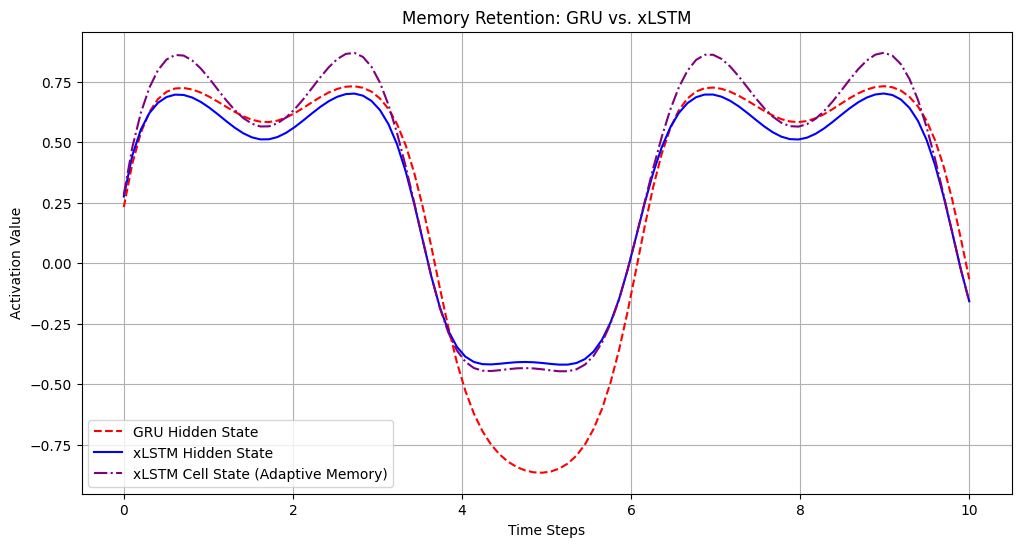

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define sigmoid function
def sigmoid(x):
    return 1 / (1 + ops.exp(-x))

# Define LeCun Tanh function
def lecun_tanh(x):
    return 1.7159 * nn.modules.activations.tanh(2/3 * x)

# Generate time sequence and input signal
time_steps = tensor.linspace(0, 10, 100)
input_signal = ops.sin(time_steps) + 0.5 * ops.cos(2 * time_steps)  # Example input sequence

# Simulate GRU gate activations
update_gate_values = sigmoid(0.5 * input_signal + 0.2)
reset_gate_values = sigmoid(0.6 * input_signal - 0.1)

# Simulate xLSTM gate activations
adaptive_decay = ops.exp(-0.1 * ops.abs(input_signal))
x_forget_gate_values = sigmoid(0.5 * input_signal - 0.2) * adaptive_decay
x_input_gate_values = sigmoid(0.7 * input_signal + 0.1 + 0.2 * x_forget_gate_values)

# Initialize variables for GRU and xLSTM
gru_hidden_state = tensor.zeros_like(time_steps)
xlstm_hidden_state = tensor.zeros_like(time_steps)
xlstm_cell_state = tensor.zeros_like(time_steps)

# Initial states
gru_hidden = 0
xlstm_hidden = 0
xlstm_cell = 0

# Simulate both GRU and xLSTM
for t in range(len(time_steps)):
    # GRU updates
    update = update_gate_values[t]
    reset = reset_gate_values[t]
    candidate_hidden = nn.modules.activations.tanh(0.8 * (reset * gru_hidden + input_signal[t]))
    gru_hidden = (1 - update) * gru_hidden + update * candidate_hidden
    gru_hidden_state[t] = gru_hidden

    # xLSTM updates
    x_forget = x_forget_gate_values[t]
    x_input_g = x_input_gate_values[t]
    x_candidate_memory = lecun_tanh(0.8 * input_signal[t])

    xlstm_cell = x_forget * xlstm_cell + x_input_g * x_candidate_memory  # Cell state update
    xlstm_hidden = nn.modules.activations.tanh(xlstm_cell)  # Hidden state update

    xlstm_hidden_state[t] = xlstm_hidden
    xlstm_cell_state[t] = xlstm_cell

# Plot GRU vs. xLSTM hidden states over time
plt.figure(figsize=(12, 6))
plt.plot(time_steps, gru_hidden_state, label="GRU Hidden State", linestyle="dashed", color="red")
plt.plot(time_steps, xlstm_hidden_state, label="xLSTM Hidden State", linestyle="solid", color="blue")
plt.plot(time_steps, xlstm_cell_state, label="xLSTM Cell State (Adaptive Memory)", linestyle="dashdot", color="purple")

# Formatting
plt.xlabel("Time Steps")
plt.ylabel("Activation Value")
plt.title("Memory Retention: GRU vs. xLSTM")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [5]:
import torch
import torch.nn as nn

class CfCNeuron(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CfCNeuron, self).__init__()
        self.hidden_dim = hidden_dim
        
        # Dense layer before CfC
        self.input_transform = nn.Linear(input_dim, hidden_dim)
        
        # CfC-specific weights
        self.W1 = nn.Linear(hidden_dim, hidden_dim)
        self.W2 = nn.Linear(hidden_dim, hidden_dim)
        self.time_gate = nn.Linear(hidden_dim, 1)  # Time interpolation
        
        # Dense layer after CfC
        self.output_layer = nn.Linear(hidden_dim, 1)  # Example: output 1 value

    def forward(self, x, h_prev):
        # Dense transformation before CfC
        z = torch.tanh(self.input_transform(x))
        
        # Compute CfC time gate
        t_interp = torch.sigmoid(self.time_gate(z))
        
        # Compute CfC hidden state update
        ff1 = torch.tanh(self.W1(z))
        ff2 = torch.tanh(self.W2(z))
        h_new = (1 - t_interp) * ff1 + t_interp * ff2

        # Dense transformation after CfC
        y = self.output_layer(h_new)

        return y, h_new  # Returning final output & updated hidden state

# Example usage
input_dim = 4  # Input feature size
hidden_dim = 8  # Hidden state size
model = CfCNeuron(input_dim, hidden_dim)

x_sample = torch.randn(1, input_dim)  # Example input
h_sample = torch.zeros(1, hidden_dim)  # Initial hidden state
y_output, new_hidden_state = model(x_sample, h_sample)

print("Output:", y_output)
print("New Hidden State:", new_hidden_state)

Output: tensor([[-0.2722]], grad_fn=<AddmmBackward0>)
New Hidden State: tensor([[-0.1227, -0.0367,  0.1161,  0.4319, -0.4230,  0.1748,  0.0105,  0.2032]],
       grad_fn=<AddBackward0>)


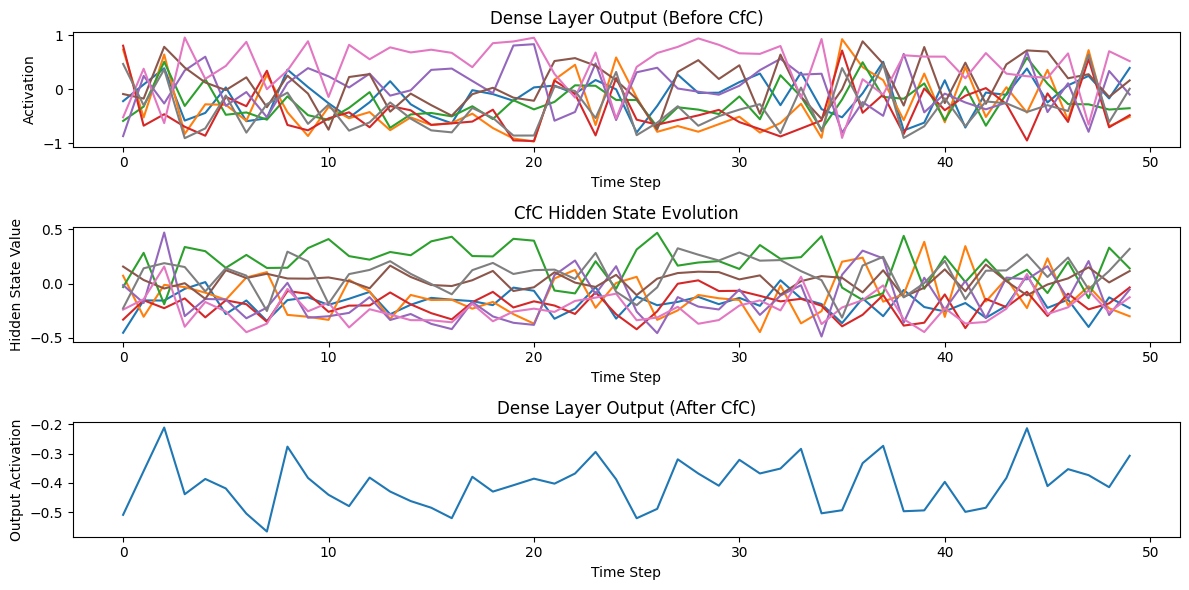

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Define a CfC neuron with Dense layers
class CfCNeuron(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CfCNeuron, self).__init__()
        self.hidden_dim = hidden_dim

        # Dense layer before CfC
        self.input_transform = nn.Linear(input_dim, hidden_dim)

        # CfC-specific weights
        self.W1 = nn.Linear(hidden_dim, hidden_dim)
        self.W2 = nn.Linear(hidden_dim, hidden_dim)
        self.time_gate = nn.Linear(hidden_dim, 1)  # Time interpolation gate

        # Dense layer after CfC
        self.output_layer = nn.Linear(hidden_dim, 1)

    def forward(self, x, h_prev):
        # Dense transformation before CfC
        z = torch.tanh(self.input_transform(x))

        # Compute CfC time gate
        t_interp = torch.sigmoid(self.time_gate(z))

        # Compute CfC hidden state update
        ff1 = torch.tanh(self.W1(z))
        ff2 = torch.tanh(self.W2(z))
        h_new = (1 - t_interp) * ff1 + t_interp * ff2

        # Dense transformation after CfC
        y = self.output_layer(h_new)

        return y, h_new

# Define simulation parameters
input_dim = 4
hidden_dim = 8
num_steps = 50

# Create CfC neuron
model = CfCNeuron(input_dim, hidden_dim)

# Generate a synthetic time-series input
x_samples = torch.randn(num_steps, input_dim)

# Initialize hidden state
h_prev = torch.zeros(1, hidden_dim)

# Track transformations at each step
hidden_states = []
outputs = []
dense_inputs = []

# Run input through CfC neuron over multiple time steps
for t in range(num_steps):
    x_t = x_samples[t].unsqueeze(0)  # Single input at timestep t
    dense_input = torch.tanh(model.input_transform(x_t))  # First Dense Layer transformation
    y, h_prev = model(x_t, h_prev)  # CfC neuron transformation

    hidden_states.append(h_prev.detach().numpy().flatten())
    outputs.append(y.detach().numpy().flatten())
    dense_inputs.append(dense_input.detach().numpy().flatten())
from ember_ml.nn import tensor
# Convert lists to NumPy arrays
hidden_states = tensor.convert_to_tensor(hidden_states)
outputs = tensor.convert_to_tensor(outputs).flatten()
dense_inputs = tensor.convert_to_tensor(dense_inputs)

# Plot how the Dense and CfC layers transform the input over time
plt.figure(figsize=(12, 6))

# Plot transformation before CfC (Dense Layer Output)
plt.subplot(3, 1, 1)
plt.plot(dense_inputs)
plt.title("Dense Layer Output (Before CfC)")
plt.xlabel("Time Step")
plt.ylabel("Activation")

# Plot CfC Hidden States
plt.subplot(3, 1, 2)
plt.plot(hidden_states)
plt.title("CfC Hidden State Evolution")
plt.xlabel("Time Step")
plt.ylabel("Hidden State Value")

# Plot final output (Dense Layer after CfC)
plt.subplot(3, 1, 3)
plt.plot(outputs, label="Final Output")
plt.title("Dense Layer Output (After CfC)")
plt.xlabel("Time Step")
plt.ylabel("Output Activation")

plt.tight_layout()
plt.show()